In [1]:
!pip install tensorflow scikit-learn matplotlib kaggle


In [2]:
from google.colab import files
files.upload()  # Upload the kaggle.json API token


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ayushpanda28","key":"d4c3246a6749279ff4965c56f1401180"}'}

In [3]:
import os
import zipfile

# Create the .kaggle directory
os.makedirs('/root/.kaggle', exist_ok=True)

# Move the kaggle.json to the correct location
os.rename("kaggle.json", "/root/.kaggle/kaggle.json")

# Change the permissions of the file to make sure it can be read
os.chmod('/root/.kaggle/kaggle.json', 600)


In [4]:
!kaggle datasets download -d aryashah2k/gastrointestinal-bleeding-images-dataset
!unzip gastrointestinal-bleeding-images-dataset.zip -d gi_bleeding_dataset/


Dataset URL: https://www.kaggle.com/datasets/aryashah2k/gastrointestinal-bleeding-images-dataset
License(s): CC-BY-SA-4.0
Archive:  gastrointestinal-bleeding-images-dataset.zip
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20211123_00022.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20211123_00023.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20211123_00024.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20220701_00001.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20220701_00002.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20220701_00003.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20220701_00008.bmp  
  inflating: gi_bleeding_dataset/GastrointestinalBleeding/Lesion/72140001224_20220701_00009.bmp  
  inflating: gi_bleeding_dataset/Gastro

In [5]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import roc_auc_score, precision_recall_curve, average_precision_score, f1_score, precision_score, recall_score, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt



In [6]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
dataset_path = '/content/gi_bleeding_dataset/GastrointestinalBleeding/'
lesion_dir = os.path.join(dataset_path, 'Lesion')
normal_dir = os.path.join(dataset_path, 'Normal')

# **Check if directories exist and contain images**
print(f"Lesion directory exists: {os.path.exists(lesion_dir)}")
print(f"Normal directory exists: {os.path.exists(normal_dir)}")

# **Check number of images per class**
num_lesion = len(os.listdir(lesion_dir))
num_normal = len(os.listdir(normal_dir))

print(f"Number of Lesion images: {num_lesion}")
print(f"Number of Normal images: {num_normal}")

# **Fix: Ensure at least 1 image in validation set**
total_images = num_lesion + num_normal
validation_split = 0.2 if total_images > 10 else 0.1  # Prevent empty validation set

# **Image preprocessing & augmentation**
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split  # **Ensure split is valid**
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# **Fix: Ensure consistent shuffle & seed for reproducibility**
seed_value = 42

# **Load training data correctly**
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed_value,  # **Ensure consistent split**
    classes=['Lesion', 'Normal']
)

# **Load validation data correctly**
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # **Fix: Now properly assigns images to validation**
    shuffle=False,  # **Do not shuffle for consistency in evaluation**
    seed=seed_value,
    classes=['Lesion', 'Normal']
)

# **Check how many images were assigned**
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")


Lesion directory exists: True
Normal directory exists: True
Number of Lesion images: 113
Number of Normal images: 113
Found 182 images belonging to 2 classes.
Found 44 images belonging to 2 classes.
✅ Training samples: 182
✅ Validation samples: 44


In [7]:
# Load DenseNet121 model (pre-trained)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [8]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



In [9]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.4761 - loss: 0.7184

6/6 ━━━━━━━━━━━━━━━━━━━━ 64s 7s/step - accuracy: 0.4960 - loss: 0.7105 - val_accuracy: 0.6591 - val_loss: 0.6123
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 485ms/step - accuracy: 0.7551 - loss: 0.5766

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 930ms/step - accuracy: 0.7524 - loss: 0.5758 - val_accuracy: 0.7500 - val_loss: 0.6095
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 533ms/step - accuracy: 0.7652 - loss: 0.5219 - val_accuracy: 0.6818 - val_loss: 0.6227
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 539ms/step - accuracy: 0.7860 - loss: 0.4741 - val_accuracy: 0.7045 - val_loss: 0.6100
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 405ms/step - accuracy: 0.8350 - loss: 0.4568

6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 879ms/step - accuracy: 0.8319 - loss: 0.4582 - val_accuracy: 0.6818 - val_loss: 0.5523
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 557ms/step - accuracy: 0.8156 - loss: 0.4734 - val_accuracy: 0.6591 - val_loss: 0.6539
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 529ms/step - accuracy: 0.8028 - loss: 0.4248 - val_accuracy: 0.7045 - val_loss: 0.5804
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 528ms/step - accuracy: 0.8608 - loss: 0.4155 - val_accuracy: 0.7045 - val_loss: 0.5795
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 4s 733ms/step - accuracy: 0.7772 - loss: 0.4229 - val_accuracy: 0.7727 - val_loss: 0.6012
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 3s 522ms/step - accuracy: 0.8684 - loss: 0.3463 - val_accuracy: 0.6818 - val_loss: 0.6268


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 153ms/step - accuracy: 0.6013 - loss: 0.6821

🔹 **Validation Accuracy (Keras evaluate): 0.6364**
2/2 ━━━━━━━━━━━━━━━━━━━━ 21s 10s/step

🔹 **Overall Validation Accuracy (sklearn accuracy_score): 0.6818**
🔹 ROC AUC Score: 0.7665
🔹 Precision-Recall AUC (AUPR): 0.7404
🔹 F1 Score: 0.7407
🔹 Precision: 0.6250
🔹 Recall: 0.9091

Confusion Matrix:
[[10 12]
 [ 2 20]]


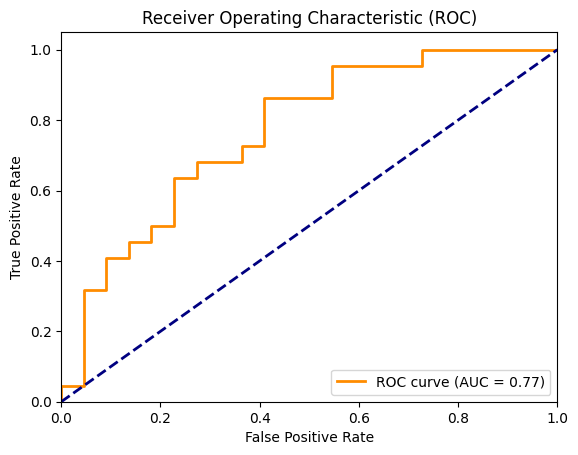

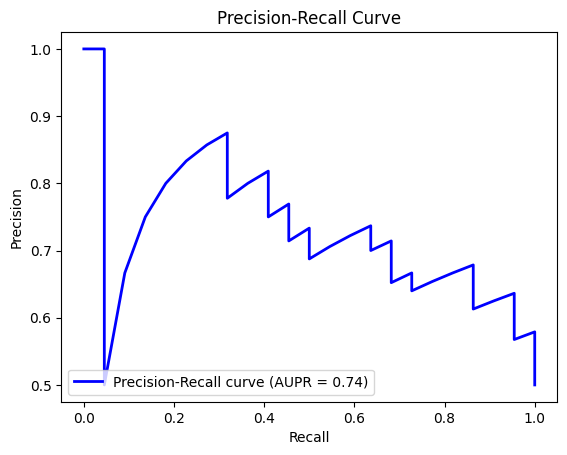

In [10]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\n🔹 **Validation Accuracy (Keras evaluate): {val_accuracy:.4f}**")

y_true = validation_generator.classes  # Actual labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities

# Convert probabilities to binary predictions using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, y_pred_prob)
aupr = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"\n🔹 **Overall Validation Accuracy (sklearn accuracy_score): {overall_accuracy:.4f}**")
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")
print(f"🔹 Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
aupr_value = average_precision_score(y_true, y_pred_prob)

plt.figure()
plt.plot(recall_vals, precision_vals, color='b', lw=2, label=f'Precision-Recall curve (AUPR = {aupr_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [11]:
# Feature Extraction Using DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract Features
def extract_features(generator):
    features = []
    labels = []

    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

    return np.vstack(features), np.hstack(labels)

# Extract features for training and validation sets
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

print(f"Extracted training features: {X_train.shape}")
print(f"Extracted validation features: {X_val.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Extracted training features: (182, 1024)
Extracted validation features: (44, 1024)


In [12]:
# **Train Random Forest Classifier**
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [13]:
# **Make Predictions**
y_pred_prob = rf_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6364
✅ ROC AUC: 0.6508
✅ Precision-Recall AUC (AUPR): 0.6486
✅ Precision: 0.6000
✅ Recall: 0.8182
✅ F1 Score: 0.6923
✅ Confusion Matrix:
[[10 12]
 [ 4 18]]


In [14]:
# **Standardize Features for SVM**
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# **Train SVM Classifier**
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [15]:
y_pred_prob = svm_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = svm_classifier.predict(X_val)  # Get predicted labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6591
✅ ROC AUC: 0.6942
✅ Precision-Recall AUC (AUPR): 0.6705
✅ Precision: 0.6061
✅ Recall: 0.9091
✅ F1 Score: 0.7273
✅ Confusion Matrix:
[[ 9 13]
 [ 2 20]]


In [16]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
# Standardize Features for XGBoost
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [17]:
y_pred_prob = xgb_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Evaluation Results
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.5909
✅ ROC AUC: 0.6736
✅ Precision-Recall AUC (AUPR): 0.6885
✅ Precision: 0.5714
✅ Recall: 0.7273
✅ F1 Score: 0.6400
✅ Confusion Matrix:
[[10 12]
 [ 6 16]]


In [18]:
# Convert to XGBoost DMatrix Format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost Model Parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train XGBoost with DMatrix
xgb_classifierdm = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-logloss:0.66527
[1]	eval-logloss:0.65144
[2]	eval-logloss:0.63304
[3]	eval-logloss:0.62595
[4]	eval-logloss:0.62359
[5]	eval-logloss:0.62648
[6]	eval-logloss:0.63516
[7]	eval-logloss:0.64268
[8]	eval-logloss:0.63613
[9]	eval-logloss:0.63694
[10]	eval-logloss:0.64719
[11]	eval-logloss:0.63259
[12]	eval-logloss:0.62821
[13]	eval-logloss:0.63550


In [19]:
y_pred_prob = xgb_classifierdm.predict(dval)  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# **Evaluation Metrics**
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.7273
✅ ROC AUC: 0.6942
✅ Precision-Recall AUC (AUPR): 0.6017
✅ Precision: 0.6923
✅ Recall: 0.8182
✅ F1 Score: 0.7500
✅ Confusion Matrix:
[[14  8]
 [ 4 18]]


In [20]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
rf = rf_classifier
svc = svm_classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Stacking Classifier (Meta-learning)
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    final_estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:16] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:18] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:19] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [21]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

models = {
    "Stacking Classifier": stacking_clf,
    "Voting Classifier": voting_clf
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:15:25] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [22]:
def evaluate_model(model, X, y, name):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    aupr = auc(recall, precision)
    precision_score_value = precision_score(y, y_pred)
    recall_score_value = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"\n🔹 **{name} Model Evaluation** 🔹")
    print(f"✅ Accuracy Score: {accuracy:.4f}")
    print(f"✅ ROC AUC: {roc_auc:.4f}")
    print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
    print(f"✅ Precision: {precision_score_value:.4f}")
    print(f"✅ Recall: {recall_score_value:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Confusion Matrix:\n{conf_matrix}")

for model_name, model in models.items():
    evaluate_model(model, X_val, y_val, model_name)



🔹 **Stacking Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.6591
✅ ROC AUC: 0.6983
✅ Precision-Recall AUC (AUPR): 0.6787
✅ Precision: 0.6400
✅ Recall: 0.7273
✅ F1 Score: 0.6809
✅ Confusion Matrix:
[[13  9]
 [ 6 16]]

🔹 **Voting Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.6591
✅ ROC AUC: 0.6818
✅ Precision-Recall AUC (AUPR): 0.6511
✅ Precision: 0.6207
✅ Recall: 0.8182
✅ F1 Score: 0.7059
✅ Confusion Matrix:
[[11 11]
 [ 4 18]]


In [23]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
dataset_path = '/content/gi_bleeding_dataset/GastrointestinalBleeding/'
lesion_dir = os.path.join(dataset_path, 'Lesion')
normal_dir = os.path.join(dataset_path, 'Normal')

# **Check if directories exist and contain images**
print(f"Lesion directory exists: {os.path.exists(lesion_dir)}")
print(f"Normal directory exists: {os.path.exists(normal_dir)}")

# **Check number of images per class**
num_lesion = len(os.listdir(lesion_dir))
num_normal = len(os.listdir(normal_dir))

print(f"Number of Lesion images: {num_lesion}")
print(f"Number of Normal images: {num_normal}")

# **Fix: Ensure at least 1 image in validation set**
total_images = num_lesion + num_normal
validation_split = 0.3 if total_images > 10 else 0.3 # Prevent empty validation set

# **Image preprocessing & augmentation**
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split  # **Ensure split is valid**
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# **Fix: Ensure consistent shuffle & seed for reproducibility**
seed_value = 42

# **Load training data correctly**
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed_value,  # **Ensure consistent split**
    classes=['Lesion', 'Normal']
)

# **Load validation data correctly**
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # **Fix: Now properly assigns images to validation**
    shuffle=False,  # **Do not shuffle for consistency in evaluation**
    seed=seed_value,
    classes=['Lesion', 'Normal']
)

# **Check how many images were assigned**
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")


Lesion directory exists: True
Normal directory exists: True
Number of Lesion images: 113
Number of Normal images: 113
Found 160 images belonging to 2 classes.
Found 66 images belonging to 2 classes.
✅ Training samples: 160
✅ Validation samples: 66


In [24]:
# Load DenseNet121 model (pre-trained)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



In [25]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



In [26]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 454ms/step - accuracy: 0.5164 - loss: 0.7280

5/5 ━━━━━━━━━━━━━━━━━━━━ 46s 6s/step - accuracy: 0.5251 - loss: 0.7214 - val_accuracy: 0.5455 - val_loss: 0.6914
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.6150 - loss: 0.6532

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 889ms/step - accuracy: 0.6135 - loss: 0.6526 - val_accuracy: 0.6667 - val_loss: 0.6595
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 885ms/step - accuracy: 0.6884 - loss: 0.5706 - val_accuracy: 0.5909 - val_loss: 0.6696
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step - accuracy: 0.7204 - loss: 0.5476

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.7285 - loss: 0.5435 - val_accuracy: 0.6970 - val_loss: 0.5928
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 427ms/step - accuracy: 0.7423 - loss: 0.5366

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step - accuracy: 0.7467 - loss: 0.5317 - val_accuracy: 0.6364 - val_loss: 0.5804
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 884ms/step - accuracy: 0.7425 - loss: 0.5008 - val_accuracy: 0.6364 - val_loss: 0.6442
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 669ms/step - accuracy: 0.7319 - loss: 0.5001 - val_accuracy: 0.6818 - val_loss: 0.6008
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 426ms/step - accuracy: 0.8391 - loss: 0.4343

5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 886ms/step - accuracy: 0.8398 - loss: 0.4332 - val_accuracy: 0.7273 - val_loss: 0.5622
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 483ms/step - accuracy: 0.7999 - loss: 0.4487

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.8041 - loss: 0.4447 - val_accuracy: 0.7727 - val_loss: 0.5376
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 657ms/step - accuracy: 0.8464 - loss: 0.4125 - val_accuracy: 0.6970 - val_loss: 0.5497


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 229ms/step - accuracy: 0.6649 - loss: 0.5939

🔹 **Validation Accuracy (Keras evaluate): 0.6970**


3/3 ━━━━━━━━━━━━━━━━━━━━ 21s 5s/step

🔹 **Overall Validation Accuracy (sklearn accuracy_score): 0.6667**
🔹 ROC AUC Score: 0.7374
🔹 Precision-Recall AUC (AUPR): 0.7326
🔹 F1 Score: 0.7105
🔹 Precision: 0.6279
🔹 Recall: 0.8182

Confusion Matrix:
[[17 16]
 [ 6 27]]


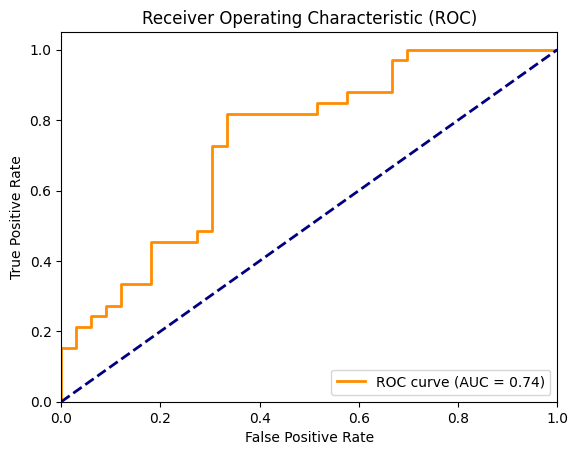

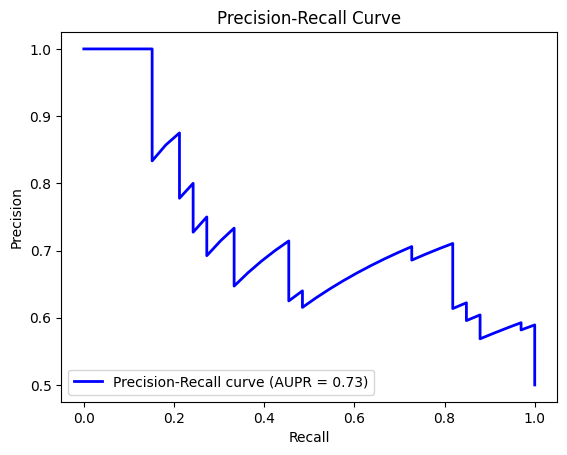

In [27]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\n🔹 **Validation Accuracy (Keras evaluate): {val_accuracy:.4f}**")

y_true = validation_generator.classes  # Actual labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities

# Convert probabilities to binary predictions using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, y_pred_prob)
aupr = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"\n🔹 **Overall Validation Accuracy (sklearn accuracy_score): {overall_accuracy:.4f}**")
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")
print(f"🔹 Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
aupr_value = average_precision_score(y_true, y_pred_prob)

plt.figure()
plt.plot(recall_vals, precision_vals, color='b', lw=2, label=f'Precision-Recall curve (AUPR = {aupr_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [28]:
# Feature Extraction Using DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract Features
def extract_features(generator):
    features = []
    labels = []

    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

    return np.vstack(features), np.hstack(labels)

# Extract features for training and validation sets
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

print(f"Extracted training features: {X_train.shape}")
print(f"Extracted validation features: {X_val.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 142ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
Extracted training features: (160, 1024)
Extracted validation features: (66, 1024)


In [29]:
# **Train Random Forest Classifier**
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [30]:
# **Make Predictions**
y_pred_prob = rf_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6515
✅ ROC AUC: 0.6827
✅ Precision-Recall AUC (AUPR): 0.6143
✅ Precision: 0.6042
✅ Recall: 0.8788
✅ F1 Score: 0.7160
✅ Confusion Matrix:
[[14 19]
 [ 4 29]]


In [31]:
# **Standardize Features for SVM**
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# **Train SVM Classifier**
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [32]:
y_pred_prob = svm_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = svm_classifier.predict(X_val)  # Get predicted labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6364
✅ ROC AUC: 0.7346
✅ Precision-Recall AUC (AUPR): 0.7222
✅ Precision: 0.5957
✅ Recall: 0.8485
✅ F1 Score: 0.7000
✅ Confusion Matrix:
[[14 19]
 [ 5 28]]


In [33]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
# Standardize Features for XGBoost
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [34]:
y_pred_prob = xgb_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Evaluation Results
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6212
✅ ROC AUC: 0.6198
✅ Precision-Recall AUC (AUPR): 0.5602
✅ Precision: 0.6000
✅ Recall: 0.7273
✅ F1 Score: 0.6575
✅ Confusion Matrix:
[[17 16]
 [ 9 24]]


In [35]:
# Convert to XGBoost DMatrix Format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost Model Parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train XGBoost with DMatrix
xgb_classifierdm = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-logloss:0.69050
[1]	eval-logloss:0.68457
[2]	eval-logloss:0.68700
[3]	eval-logloss:0.67262
[4]	eval-logloss:0.65605
[5]	eval-logloss:0.64923
[6]	eval-logloss:0.64890
[7]	eval-logloss:0.63643
[8]	eval-logloss:0.63286
[9]	eval-logloss:0.63819
[10]	eval-logloss:0.63471
[11]	eval-logloss:0.62999
[12]	eval-logloss:0.62384
[13]	eval-logloss:0.62999
[14]	eval-logloss:0.62500
[15]	eval-logloss:0.62065
[16]	eval-logloss:0.62173
[17]	eval-logloss:0.61503
[18]	eval-logloss:0.61441
[19]	eval-logloss:0.60800
[20]	eval-logloss:0.61322
[21]	eval-logloss:0.62095
[22]	eval-logloss:0.62485
[23]	eval-logloss:0.63136
[24]	eval-logloss:0.63393
[25]	eval-logloss:0.63276
[26]	eval-logloss:0.63120
[27]	eval-logloss:0.63581
[28]	eval-logloss:0.63364
[29]	eval-logloss:0.63410


In [36]:
y_pred_prob = xgb_classifierdm.predict(dval)  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# **Evaluation Metrics**
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6364
✅ ROC AUC: 0.7254
✅ Precision-Recall AUC (AUPR): 0.7102
✅ Precision: 0.5957
✅ Recall: 0.8485
✅ F1 Score: 0.7000
✅ Confusion Matrix:
[[14 19]
 [ 5 28]]


In [37]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
rf = rf_classifier
svc = svm_classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Stacking Classifier (Meta-learning)
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    final_estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:46] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:49] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:52] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [38]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

models = {
    "Stacking Classifier": stacking_clf,
    "Voting Classifier": voting_clf
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:17:54] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [39]:
def evaluate_model(model, X, y, name):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    aupr = auc(recall, precision)
    precision_score_value = precision_score(y, y_pred)
    recall_score_value = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"\n🔹 **{name} Model Evaluation** 🔹")
    print(f"✅ Accuracy Score: {accuracy:.4f}")
    print(f"✅ ROC AUC: {roc_auc:.4f}")
    print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
    print(f"✅ Precision: {precision_score_value:.4f}")
    print(f"✅ Recall: {recall_score_value:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Confusion Matrix:\n{conf_matrix}")

for model_name, model in models.items():
    evaluate_model(model, X_val, y_val, model_name)



🔹 **Stacking Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.6364
✅ ROC AUC: 0.6685
✅ Precision-Recall AUC (AUPR): 0.6271
✅ Precision: 0.5918
✅ Recall: 0.8788
✅ F1 Score: 0.7073
✅ Confusion Matrix:
[[13 20]
 [ 4 29]]

🔹 **Voting Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.6212
✅ ROC AUC: 0.6777
✅ Precision-Recall AUC (AUPR): 0.6221
✅ Precision: 0.5870
✅ Recall: 0.8182
✅ F1 Score: 0.6835
✅ Confusion Matrix:
[[14 19]
 [ 6 27]]


In [40]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
dataset_path = '/content/gi_bleeding_dataset/GastrointestinalBleeding/'
lesion_dir = os.path.join(dataset_path, 'Lesion')
normal_dir = os.path.join(dataset_path, 'Normal')

# **Check if directories exist and contain images**
print(f"Lesion directory exists: {os.path.exists(lesion_dir)}")
print(f"Normal directory exists: {os.path.exists(normal_dir)}")

# **Check number of images per class**
num_lesion = len(os.listdir(lesion_dir))
num_normal = len(os.listdir(normal_dir))

print(f"Number of Lesion images: {num_lesion}")
print(f"Number of Normal images: {num_normal}")

# **Fix: Ensure at least 1 image in validation set**
total_images = num_lesion + num_normal
validation_split = 0.4 if total_images > 10 else 0.4  # Prevent empty validation set

# **Image preprocessing & augmentation**
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split  # **Ensure split is valid**
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# **Fix: Ensure consistent shuffle & seed for reproducibility**
seed_value = 42

# **Load training data correctly**
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed_value,  # **Ensure consistent split**
    classes=['Lesion', 'Normal']
)

# **Load validation data correctly**
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # **Fix: Now properly assigns images to validation**
    shuffle=False,  # **Do not shuffle for consistency in evaluation**
    seed=seed_value,
    classes=['Lesion', 'Normal']
)

# **Check how many images were assigned**
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")


Lesion directory exists: True
Normal directory exists: True
Number of Lesion images: 113
Number of Normal images: 113
Found 136 images belonging to 2 classes.
Found 90 images belonging to 2 classes.
✅ Training samples: 136
✅ Validation samples: 90


In [41]:
# Load DenseNet121 model (pre-trained)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



In [42]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



In [43]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6038 - loss: 0.6670   

5/5 ━━━━━━━━━━━━━━━━━━━━ 58s 9s/step - accuracy: 0.6049 - loss: 0.6675 - val_accuracy: 0.6556 - val_loss: 0.6305
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 702ms/step - accuracy: 0.6337 - loss: 0.6146 - val_accuracy: 0.6000 - val_loss: 0.6738
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 570ms/step - accuracy: 0.7679 - loss: 0.5704

5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 1s/step - accuracy: 0.7698 - loss: 0.5680 - val_accuracy: 0.6889 - val_loss: 0.6224
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step - accuracy: 0.7965 - loss: 0.4968 - val_accuracy: 0.6333 - val_loss: 0.6459
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 763ms/step - accuracy: 0.7939 - loss: 0.4945 - val_accuracy: 0.6333 - val_loss: 0.6301
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 4s 875ms/step - accuracy: 0.8259 - loss: 0.4707 - val_accuracy: 0.6667 - val_loss: 0.6352
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 660ms/step - accuracy: 0.8238 - loss: 0.4529 - val_accuracy: 0.6222 - val_loss: 0.6467
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 662ms/step - accuracy: 0.8653 - loss: 0.4202 - val_accuracy: 0.6556 - val_loss: 0.6286


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 382ms/step - accuracy: 0.6146 - loss: 0.6634

🔹 **Validation Accuracy (Keras evaluate): 0.6667**
3/3 ━━━━━━━━━━━━━━━━━━━━ 32s 8s/step

🔹 **Overall Validation Accuracy (sklearn accuracy_score): 0.6889**
🔹 ROC AUC Score: 0.7659
🔹 Precision-Recall AUC (AUPR): 0.7368
🔹 F1 Score: 0.7358
🔹 Precision: 0.6393
🔹 Recall: 0.8667

Confusion Matrix:
[[23 22]
 [ 6 39]]


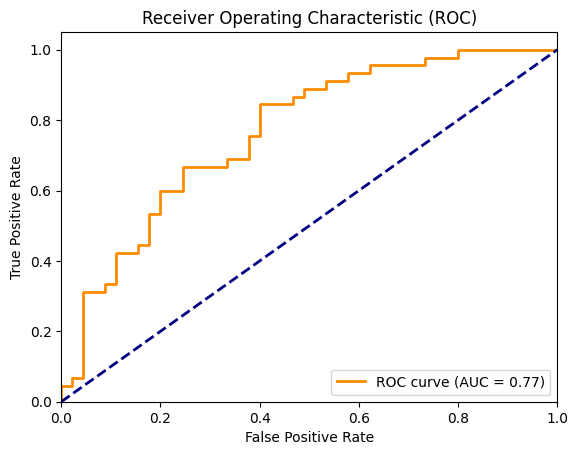

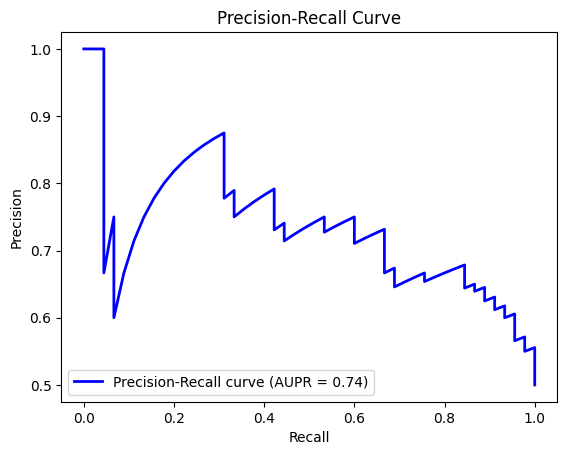

In [44]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\n🔹 **Validation Accuracy (Keras evaluate): {val_accuracy:.4f}**")

y_true = validation_generator.classes  # Actual labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities

# Convert probabilities to binary predictions using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, y_pred_prob)
aupr = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"\n🔹 **Overall Validation Accuracy (sklearn accuracy_score): {overall_accuracy:.4f}**")
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")
print(f"🔹 Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
aupr_value = average_precision_score(y_true, y_pred_prob)

plt.figure()
plt.plot(recall_vals, precision_vals, color='b', lw=2, label=f'Precision-Recall curve (AUPR = {aupr_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [45]:
# Feature Extraction Using DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract Features
def extract_features(generator):
    features = []
    labels = []

    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

    return np.vstack(features), np.hstack(labels)

# Extract features for training and validation sets
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

print(f"Extracted training features: {X_train.shape}")
print(f"Extracted validation features: {X_val.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 10s 10s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Extracted training features: (136, 1024)
Extracted validation features: (90, 1024)


In [46]:
# **Train Random Forest Classifier**
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [47]:
# **Make Predictions**
y_pred_prob = rf_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.5667
✅ ROC AUC: 0.6943
✅ Precision-Recall AUC (AUPR): 0.7390
✅ Precision: 0.5517
✅ Recall: 0.7111
✅ F1 Score: 0.6214
✅ Confusion Matrix:
[[19 26]
 [13 32]]


In [48]:
# **Standardize Features for SVM**
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# **Train SVM Classifier**
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [49]:
y_pred_prob = svm_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = svm_classifier.predict(X_val)  # Get predicted labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.5556
✅ ROC AUC: 0.6731
✅ Precision-Recall AUC (AUPR): 0.7211
✅ Precision: 0.5362
✅ Recall: 0.8222
✅ F1 Score: 0.6491
✅ Confusion Matrix:
[[13 32]
 [ 8 37]]


In [50]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
# Standardize Features for XGBoost
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [51]:
y_pred_prob = xgb_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Evaluation Results
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.5889
✅ ROC AUC: 0.6726
✅ Precision-Recall AUC (AUPR): 0.6517
✅ Precision: 0.5667
✅ Recall: 0.7556
✅ F1 Score: 0.6476
✅ Confusion Matrix:
[[19 26]
 [11 34]]


In [52]:
# Convert to XGBoost DMatrix Format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost Model Parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train XGBoost with DMatrix
xgb_classifierdm = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-logloss:0.67652
[1]	eval-logloss:0.66942
[2]	eval-logloss:0.65763
[3]	eval-logloss:0.65609
[4]	eval-logloss:0.64752
[5]	eval-logloss:0.64649
[6]	eval-logloss:0.64579
[7]	eval-logloss:0.64531
[8]	eval-logloss:0.64242
[9]	eval-logloss:0.65334
[10]	eval-logloss:0.65687
[11]	eval-logloss:0.65666
[12]	eval-logloss:0.66015
[13]	eval-logloss:0.65849
[14]	eval-logloss:0.65783
[15]	eval-logloss:0.66075
[16]	eval-logloss:0.65964
[17]	eval-logloss:0.66406
[18]	eval-logloss:0.66001


In [53]:
y_pred_prob = xgb_classifierdm.predict(dval)  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# **Evaluation Metrics**
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.5889
✅ ROC AUC: 0.6662
✅ Precision-Recall AUC (AUPR): 0.6351
✅ Precision: 0.5741
✅ Recall: 0.6889
✅ F1 Score: 0.6263
✅ Confusion Matrix:
[[22 23]
 [14 31]]


In [54]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
rf = rf_classifier
svc = svm_classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Stacking Classifier (Meta-learning)
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    final_estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:30] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:32] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:33] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [55]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

models = {
    "Stacking Classifier": stacking_clf,
    "Voting Classifier": voting_clf
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:20:34] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [56]:
def evaluate_model(model, X, y, name):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    aupr = auc(recall, precision)
    precision_score_value = precision_score(y, y_pred)
    recall_score_value = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"\n🔹 **{name} Model Evaluation** 🔹")
    print(f"✅ Accuracy Score: {accuracy:.4f}")
    print(f"✅ ROC AUC: {roc_auc:.4f}")
    print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
    print(f"✅ Precision: {precision_score_value:.4f}")
    print(f"✅ Recall: {recall_score_value:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Confusion Matrix:\n{conf_matrix}")

for model_name, model in models.items():
    evaluate_model(model, X_val, y_val, model_name)



🔹 **Stacking Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.5556
✅ ROC AUC: 0.5891
✅ Precision-Recall AUC (AUPR): 0.5504
✅ Precision: 0.5362
✅ Recall: 0.8222
✅ F1 Score: 0.6491
✅ Confusion Matrix:
[[13 32]
 [ 8 37]]

🔹 **Voting Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.5889
✅ ROC AUC: 0.6904
✅ Precision-Recall AUC (AUPR): 0.7328
✅ Precision: 0.5645
✅ Recall: 0.7778
✅ F1 Score: 0.6542
✅ Confusion Matrix:
[[18 27]
 [10 35]]


In [57]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define dataset paths
dataset_path = '/content/gi_bleeding_dataset/GastrointestinalBleeding/'
lesion_dir = os.path.join(dataset_path, 'Lesion')
normal_dir = os.path.join(dataset_path, 'Normal')

# **Check if directories exist and contain images**
print(f"Lesion directory exists: {os.path.exists(lesion_dir)}")
print(f"Normal directory exists: {os.path.exists(normal_dir)}")

# **Check number of images per class**
num_lesion = len(os.listdir(lesion_dir))
num_normal = len(os.listdir(normal_dir))

print(f"Number of Lesion images: {num_lesion}")
print(f"Number of Normal images: {num_normal}")

# **Fix: Ensure at least 1 image in validation set**
total_images = num_lesion + num_normal
validation_split = 0.1 if total_images > 10 else 0.1 # Prevent empty validation set

# **Image preprocessing & augmentation**
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=validation_split  # **Ensure split is valid**
)

# Validation data generator (only rescaling, no augmentation)
validation_datagen = ImageDataGenerator(rescale=1./255)

# **Fix: Ensure consistent shuffle & seed for reproducibility**
seed_value = 42

# **Load training data correctly**
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='training',
    shuffle=True,
    seed=seed_value,  # **Ensure consistent split**
    classes=['Lesion', 'Normal']
)

# **Load validation data correctly**
validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    subset='validation',  # **Fix: Now properly assigns images to validation**
    shuffle=False,  # **Do not shuffle for consistency in evaluation**
    seed=seed_value,
    classes=['Lesion', 'Normal']
)

# **Check how many images were assigned**
print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {validation_generator.samples}")


Lesion directory exists: True
Normal directory exists: True
Number of Lesion images: 113
Number of Normal images: 113
Found 204 images belonging to 2 classes.
Found 22 images belonging to 2 classes.
✅ Training samples: 204
✅ Validation samples: 22


In [58]:
# Load DenseNet121 model (pre-trained)
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model layers

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)  # Binary classification

# Define the model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])



In [59]:
# Callbacks for early stopping and saving best model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)



In [60]:
# Train the model
history = model.fit(
    train_generator,
    epochs=10,
    validation_data=validation_generator,
    callbacks=[early_stopping, model_checkpoint]
)



/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5335 - loss: 0.7242

7/7 ━━━━━━━━━━━━━━━━━━━━ 46s 4s/step - accuracy: 0.5367 - loss: 0.7214 - val_accuracy: 0.5455 - val_loss: 0.7392
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.6821 - loss: 0.6136

7/7 ━━━━━━━━━━━━━━━━━━━━ 14s 679ms/step - accuracy: 0.6820 - loss: 0.6128 - val_accuracy: 0.4091 - val_loss: 0.6922
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step - accuracy: 0.7282 - loss: 0.5747

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 637ms/step - accuracy: 0.7297 - loss: 0.5717 - val_accuracy: 0.6364 - val_loss: 0.6890
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 3s 442ms/step - accuracy: 0.7037 - loss: 0.5363 - val_accuracy: 0.5909 - val_loss: 0.6914
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step - accuracy: 0.7727 - loss: 0.4720

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 691ms/step - accuracy: 0.7730 - loss: 0.4748 - val_accuracy: 0.6818 - val_loss: 0.6570
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 380ms/step - accuracy: 0.8123 - loss: 0.4560

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.8094 - loss: 0.4579 - val_accuracy: 0.6818 - val_loss: 0.5756
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 373ms/step - accuracy: 0.7397 - loss: 0.4870

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.7447 - loss: 0.4825 - val_accuracy: 0.6818 - val_loss: 0.5234
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.8174 - loss: 0.4298

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.8170 - loss: 0.4286 - val_accuracy: 0.6818 - val_loss: 0.5008
Epoch 9/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 376ms/step - accuracy: 0.8390 - loss: 0.3991

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 594ms/step - accuracy: 0.8383 - loss: 0.3986 - val_accuracy: 0.6818 - val_loss: 0.4846
Epoch 10/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step - accuracy: 0.7928 - loss: 0.4278

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 590ms/step - accuracy: 0.7936 - loss: 0.4270 - val_accuracy: 0.8182 - val_loss: 0.4816


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step - accuracy: 0.7727 - loss: 0.5490

🔹 **Validation Accuracy (Keras evaluate): 0.7727**
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step

🔹 **Overall Validation Accuracy (sklearn accuracy_score): 0.8182**
🔹 ROC AUC Score: 0.8843
🔹 Precision-Recall AUC (AUPR): 0.8937
🔹 F1 Score: 0.8462
🔹 Precision: 0.7333
🔹 Recall: 1.0000

Confusion Matrix:
[[ 7  4]
 [ 0 11]]


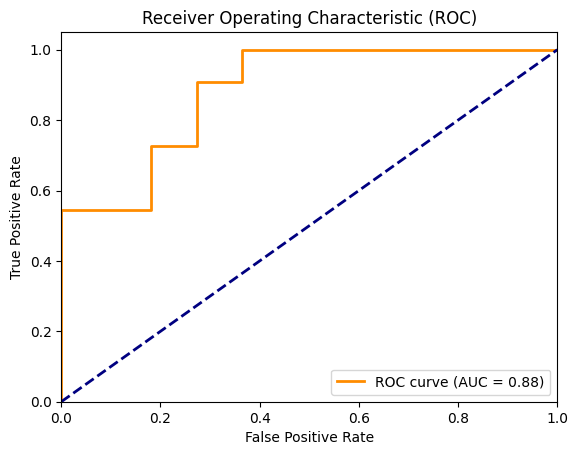

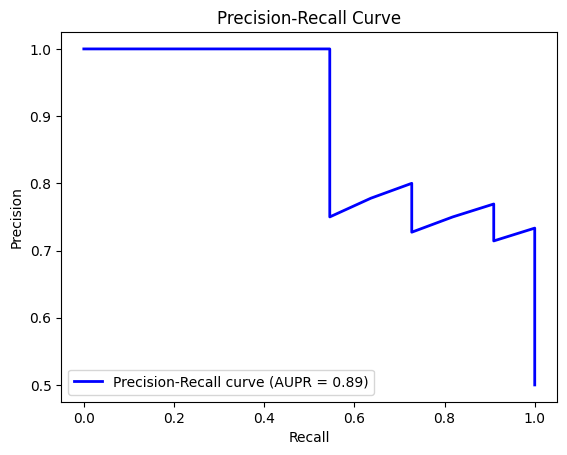

In [61]:
val_loss, val_accuracy = model.evaluate(validation_generator)
print(f"\n🔹 **Validation Accuracy (Keras evaluate): {val_accuracy:.4f}**")

y_true = validation_generator.classes  # Actual labels
y_pred_prob = model.predict(validation_generator)  # Predicted probabilities

# Convert probabilities to binary predictions using threshold 0.5
y_pred = (y_pred_prob > 0.5).astype(int)

roc_auc = roc_auc_score(y_true, y_pred_prob)
aupr = average_precision_score(y_true, y_pred_prob)
f1 = f1_score(y_true, y_pred)
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)
conf_mat = confusion_matrix(y_true, y_pred)
overall_accuracy = accuracy_score(y_true, y_pred)

print(f"\n🔹 **Overall Validation Accuracy (sklearn accuracy_score): {overall_accuracy:.4f}**")
print(f"🔹 ROC AUC Score: {roc_auc:.4f}")
print(f"🔹 Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"🔹 F1 Score: {f1:.4f}")
print(f"🔹 Precision: {precision:.4f}")
print(f"🔹 Recall: {recall:.4f}")
print("\nConfusion Matrix:")
print(conf_mat)


# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
roc_auc_value = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_value:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

# Precision-Recall Curve
precision_vals, recall_vals, _ = precision_recall_curve(y_true, y_pred_prob)
aupr_value = average_precision_score(y_true, y_pred_prob)

plt.figure()
plt.plot(recall_vals, precision_vals, color='b', lw=2, label=f'Precision-Recall curve (AUPR = {aupr_value:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()


In [62]:
# Feature Extraction Using DenseNet121
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
feature_extractor = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))

# Extract Features
def extract_features(generator):
    features = []
    labels = []

    for _ in range(len(generator)):
        batch_images, batch_labels = next(generator)
        batch_features = feature_extractor.predict(batch_images)
        features.append(batch_features)
        labels.append(batch_labels)

    return np.vstack(features), np.hstack(labels)

# Extract features for training and validation sets
X_train, y_train = extract_features(train_generator)
X_val, y_val = extract_features(validation_generator)

print(f"Extracted training features: {X_train.shape}")
print(f"Extracted validation features: {X_val.shape}")



1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 159ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 11s 11s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
Extracted training features: (204, 1024)
Extracted validation features: (22, 1024)


In [63]:
# **Train Random Forest Classifier**
from sklearn.ensemble import RandomForestClassifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [64]:
# **Make Predictions**
y_pred_prob = rf_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert to binary labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6818
✅ ROC AUC: 0.7769
✅ Precision-Recall AUC (AUPR): 0.7870
✅ Precision: 0.6250
✅ Recall: 0.9091
✅ F1 Score: 0.7407
✅ Confusion Matrix:
[[ 5  6]
 [ 1 10]]


In [65]:
# **Standardize Features for SVM**
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# **Train SVM Classifier**
svm_classifier = SVC(kernel='rbf', probability=True, random_state=42)
svm_classifier.fit(X_train, y_train)

SVC(probability=True, random_state=42)

In [66]:
y_pred_prob = svm_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = svm_classifier.predict(X_val)  # Get predicted labels

# **Evaluation Metrics**
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6818
✅ ROC AUC: 0.9174
✅ Precision-Recall AUC (AUPR): 0.9307
✅ Precision: 0.6250
✅ Recall: 0.9091
✅ F1 Score: 0.7407
✅ Confusion Matrix:
[[ 5  6]
 [ 1 10]]


In [67]:
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
# Standardize Features for XGBoost
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)

# Train XGBoost Classifier
xgb_classifier = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    random_state=42
)

xgb_classifier.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:22:58] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [68]:
y_pred_prob = xgb_classifier.predict_proba(X_val)[:, 1]  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# Evaluation Metrics
accuracy = np.mean(y_pred == y_val)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print Evaluation Results
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.6818
✅ ROC AUC: 0.8017
✅ Precision-Recall AUC (AUPR): 0.6959
✅ Precision: 0.6111
✅ Recall: 1.0000
✅ F1 Score: 0.7586
✅ Confusion Matrix:
[[ 4  7]
 [ 0 11]]


In [69]:
# Convert to XGBoost DMatrix Format
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# XGBoost Model Parameters
params = {
    'objective': 'binary:logistic',  # Binary classification
    'eval_metric': 'logloss',
    'eta': 0.1,  # Learning rate
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42
}

# Train XGBoost with DMatrix
xgb_classifierdm = xgb.train(params, dtrain, num_boost_round=100, evals=[(dval, 'eval')], early_stopping_rounds=10)

[0]	eval-logloss:0.64863
[1]	eval-logloss:0.60726
[2]	eval-logloss:0.58657
[3]	eval-logloss:0.57414
[4]	eval-logloss:0.58180
[5]	eval-logloss:0.57362
[6]	eval-logloss:0.58003
[7]	eval-logloss:0.58341
[8]	eval-logloss:0.58458
[9]	eval-logloss:0.58331
[10]	eval-logloss:0.58203
[11]	eval-logloss:0.59172
[12]	eval-logloss:0.59843
[13]	eval-logloss:0.59032
[14]	eval-logloss:0.57523
[15]	eval-logloss:0.55125
[16]	eval-logloss:0.55315
[17]	eval-logloss:0.55015
[18]	eval-logloss:0.54576
[19]	eval-logloss:0.55407
[20]	eval-logloss:0.55746
[21]	eval-logloss:0.52808
[22]	eval-logloss:0.52749
[23]	eval-logloss:0.53766
[24]	eval-logloss:0.52307
[25]	eval-logloss:0.52653
[26]	eval-logloss:0.52237
[27]	eval-logloss:0.52752
[28]	eval-logloss:0.53011
[29]	eval-logloss:0.52299
[30]	eval-logloss:0.52664
[31]	eval-logloss:0.53087
[32]	eval-logloss:0.53755
[33]	eval-logloss:0.53076
[34]	eval-logloss:0.51677
[35]	eval-logloss:0.52210
[36]	eval-logloss:0.53214
[37]	eval-logloss:0.53512
[38]	eval-logloss:0.53

In [70]:
y_pred_prob = xgb_classifierdm.predict(dval)  # Get probability for positive class
y_pred = (y_pred_prob > 0.5).astype(int)  # Convert probabilities to class labels

# **Evaluation Metrics**
accuracy = accuracy_score(y_val, y_pred)
roc_auc = roc_auc_score(y_val, y_pred_prob)
precision, recall, _ = precision_recall_curve(y_val, y_pred_prob)
aupr = auc(recall, precision)
precision_score_value = precision_score(y_val, y_pred)
recall_score_value = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# **Print Evaluation Results**
print(f"✅ Accuracy Score: {accuracy:.4f}")
print(f"✅ ROC AUC: {roc_auc:.4f}")
print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
print(f"✅ Precision: {precision_score_value:.4f}")
print(f"✅ Recall: {recall_score_value:.4f}")
print(f"✅ F1 Score: {f1:.4f}")
print(f"✅ Confusion Matrix:\n{conf_matrix}")


✅ Accuracy Score: 0.7273
✅ ROC AUC: 0.8512
✅ Precision-Recall AUC (AUPR): 0.8281
✅ Precision: 0.6471
✅ Recall: 1.0000
✅ F1 Score: 0.7857
✅ Confusion Matrix:
[[ 5  6]
 [ 0 11]]


In [71]:
from sklearn.ensemble import StackingClassifier, VotingClassifier
from xgboost import XGBClassifier
rf = rf_classifier
svc = svm_classifier
xgb_model = XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False)

# Stacking Classifier (Meta-learning)
stacking_clf = StackingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    final_estimator=XGBClassifier(objective='binary:logistic', eval_metric='logloss', use_label_encoder=False),
    passthrough=True
)
stacking_clf.fit(X_train, y_train)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:02] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:06] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:07] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

StackingClassifier(estimators=[('rf', RandomForestClassifier(random_state=42)),
                               ('svc', SVC(probability=True, random_state=42)),
                               ('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_...
                                                 importance_type=None,
                                                 interaction_constraints=None,
                                                 learning_rate=None,
                                                 max_bin=None,
                                                 max_cat_threshold=None,
                                                 max_cat_to_onehot=None,
                                                 max_delta_step=None,
                                                 max_depth=None,
                                                 max_leaves=None,
                                                 min_child_weight=None,
                                                 missing=nan,
                                                 monotone_constraints=None,
                                                 multi_strategy=None,
                                                 n_estimators=None, n_jobs=None,
                                                 num_parallel_tree=None,
                                                 random_state=None, ...),
                   passthrough=True)

In [72]:
voting_clf = VotingClassifier(
    estimators=[('rf', rf), ('svc', svc), ('xgb', xgb_model)],
    voting='soft'
)
voting_clf.fit(X_train, y_train)

models = {
    "Stacking Classifier": stacking_clf,
    "Voting Classifier": voting_clf
}


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:23:13] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [73]:
def evaluate_model(model, X, y, name):
    y_pred_prob = model.predict_proba(X)[:, 1]
    y_pred = (y_pred_prob > 0.5).astype(int)

    accuracy = accuracy_score(y, y_pred)
    roc_auc = roc_auc_score(y, y_pred_prob)
    precision, recall, _ = precision_recall_curve(y, y_pred_prob)
    aupr = auc(recall, precision)
    precision_score_value = precision_score(y, y_pred)
    recall_score_value = recall_score(y, y_pred)
    f1 = f1_score(y, y_pred)
    conf_matrix = confusion_matrix(y, y_pred)

    print(f"\n🔹 **{name} Model Evaluation** 🔹")
    print(f"✅ Accuracy Score: {accuracy:.4f}")
    print(f"✅ ROC AUC: {roc_auc:.4f}")
    print(f"✅ Precision-Recall AUC (AUPR): {aupr:.4f}")
    print(f"✅ Precision: {precision_score_value:.4f}")
    print(f"✅ Recall: {recall_score_value:.4f}")
    print(f"✅ F1 Score: {f1:.4f}")
    print(f"✅ Confusion Matrix:\n{conf_matrix}")

for model_name, model in models.items():
    evaluate_model(model, X_val, y_val, model_name)



🔹 **Stacking Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.7273
✅ ROC AUC: 0.8595
✅ Precision-Recall AUC (AUPR): 0.8472
✅ Precision: 0.6667
✅ Recall: 0.9091
✅ F1 Score: 0.7692
✅ Confusion Matrix:
[[ 6  5]
 [ 1 10]]

🔹 **Voting Classifier Model Evaluation** 🔹
✅ Accuracy Score: 0.6364
✅ ROC AUC: 0.8843
✅ Precision-Recall AUC (AUPR): 0.9085
✅ Precision: 0.5882
✅ Recall: 0.9091
✅ F1 Score: 0.7143
✅ Confusion Matrix:
[[ 4  7]
 [ 1 10]]
